In [15]:
!pip install DeepXDE

In [16]:
!pip install pyarrow

In [17]:
pip install --upgrade torch

Note: you may need to restart the kernel to use updated packages.


In [18]:
import torch
print(torch.__version__)

2.4.1+cu121


In [19]:
import os
os.environ["DDE_BACKEND"] = "pytorch"

In [20]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import pandas as pd
import pyarrow as pa
import pyarrow.orc as orc
from IPython.display import display

In [21]:
x_l = -20
x_r = 20
t_lower = 0
t_upper = 2

x = np.linspace(x_l, x_r, 200)
t = np.linspace(t_lower, t_upper, 50)
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

space_domain = dde.geometry.Interval(x_l, x_r)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)


k = 1
χ = 1
a = 0.5
x_0 = 15
θ_0 = np.pi / 3

a1 = 1
a2 = 1
a4 = 0.3
a6 = 0.1

b1 = 1

A1 = np.sqrt((2 * χ / b1) * (a2 - 6 * a4 * k ** 2 + 12 * a4 * k + 10 * a4 + 75 * a6 * k ** 4 + 150 * a6 * k ** 2 + 91 * a6))
C0 = a1 + 2 * a2 * k + 8 * a4 * k ** 3 + 96 * a6 * k ** 5
ω = a1 * k + a2 * k ** 2 - a2 + 3 * a4 * k ** 4 - 6 * a4 * k ** 2 - a4 + 35 * a6 * k ** 6 - 75 * a6 * k ** 4 - 15 * a6 * k ** 2 - a6

a3 = -4 * a4 * k - 40 * a6 * k ** 3
a5 = -6 * a6 * k

b2 = - (24 * a4 * χ ** 2 + 360 * a6 * χ ** 2 * k ** 2 + 840 * a6 * χ ** 2) / A1 ** 4
b3 = 720 * a6 * χ ** 3 / A1 ** 6


def pde(x, y):
    u = y[:, 0:1]
    v = y[:, 1:2]

    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_x = dde.grad.jacobian(y, x, i=0, j=0)
    v_x = dde.grad.jacobian(y, x, i=1, j=0)

    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    u_xxx = dde.grad.jacobian(u_xx, x, j=0)
    v_xxx = dde.grad.jacobian(v_xx, x, j=0)

    u_xxxx = dde.grad.jacobian(u_xxx, x, j=0)
    v_xxxx = dde.grad.jacobian(v_xxx, x, j=0)

    u_xxxxx = dde.grad.jacobian(u_xxxx, x, j=0)
    v_xxxxx = dde.grad.jacobian(v_xxxx, x, j=0)

    u_xxxxxx = dde.grad.jacobian(u_xxxxx, x, j=0)
    v_xxxxxx = dde.grad.jacobian(v_xxxxx, x, j=0)

    f_u = -v_t - a1 * v_x + a2 * u_xx - a3 * v_xxx + a4 * u_xxxx - a5 * v_xxxxx + a6 * u_xxxxxx + u * (b1 * (u ** 2 + v ** 2) + b2 * (u ** 2 + v ** 2) ** 2 + b3 * (u ** 2 + v ** 2) ** 3)
    f_v = u_t + a1 * u_x + a2 * v_xx + a3 * u_xxx + a4 * v_xxxx + a5 * u_xxxxx + a6 * v_xxxxxx + v * (b1 * (u ** 2 + v ** 2) + b2 * (u ** 2 + v ** 2) ** 2 + b3 * (u ** 2 + v ** 2) ** 3)

    return [f_u, f_v]


bc_u_0 = dde.icbc.DirichletBC(
    geomtime, lambda _: 0, lambda _, on_boundary: on_boundary, component=0
)
bc_v_0 = dde.icbc.DirichletBC(
    geomtime, lambda _: 0, lambda _, on_boundary: on_boundary, component=1
)


bc_u_1 = dde.icbc.NeumannBC(
    geomtime, lambda _: 0, lambda _, on_boundary: on_boundary, component=0
)
bc_v_1 = dde.icbc.NeumannBC(
    geomtime, lambda _: 0, lambda _, on_boundary: on_boundary, component=1
)


bc_u_2 = dde.icbc.OperatorBC(
    geomtime, lambda x, u, _: dde.grad.hessian(u, x, i=0, j=0),
    lambda _, on_boundary: on_boundary
)
bc_v_2 = dde.icbc.OperatorBC(
    geomtime, lambda x, v, _: dde.grad.hessian(v, x, i=0, j=0),
    lambda _, on_boundary: on_boundary
)


def g(x, a, b, c):
    return a * np.exp(-(x - b) ** 2 / (2 * c ** 2))


def init_cond_u(x):
    return g(np.float32(x[:, 0:1]), 8, -5, 0.5)


def init_cond_v(x):

    return 0


ic_u = dde.icbc.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)


data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u_0, bc_u_1, bc_u_2, bc_v_0, bc_v_1, bc_v_2, ic_u, ic_v],
    num_domain=5000,
    num_boundary=100,
    num_initial=1500,
    train_distribution="pseudo",
)

net = dde.nn.FNN([2] + [32] * 4 + [2], "sin", "Glorot normal")

model = dde.Model(data, net)

opt = torch.optim.Adam(model.net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

model.compile(optimizer=opt, lr=0.01, loss="MSE",
              loss_weights=(1/1000, 1/1000, 49/1000, 49/1000, 49/1000, 49/1000, 49/1000, 49/1000, 950/1000, 950/1000),
              decay=("inverse time", 100, 0.01143))
model.train(iterations=30000, display_every=1000, callbacks=[dde.callbacks.PDEPointResampler(period=10)])

Compiling model...
'compile' took 0.000361 s

Training model...

0         [1.05e-03, 5.46e-04, 1.37e-02, 2.33e-04, 2.47e-04, 3.07e-03, 8.89e-04, 2.47e-04, 1.55e+00, 3.21e-01]    [1.05e-03, 5.46e-04, 1.37e-02, 2.33e-04, 2.47e-04, 3.07e-03, 8.89e-04, 2.47e-04, 1.55e+00, 3.21e-01]    []  
1000      [3.22e-03, 2.68e-03, 9.49e-06, 8.07e-06, 4.57e-06, 2.29e-05, 1.10e-05, 4.57e-06, 7.42e-03, 5.82e-03]    [2.97e-03, 2.40e-03, 9.49e-06, 8.07e-06, 4.57e-06, 2.29e-05, 1.10e-05, 4.57e-06, 7.42e-03, 5.82e-03]    []  
2000      [1.95e-03, 1.75e-03, 4.58e-06, 5.42e-06, 2.32e-06, 3.98e-06, 5.00e-06, 2.32e-06, 5.33e-03, 4.33e-03]    [1.93e-03, 2.03e-03, 4.58e-06, 5.42e-06, 2.32e-06, 3.98e-06, 5.00e-06, 2.32e-06, 5.33e-03, 4.33e-03]    []  
3000      [1.70e-03, 1.48e-03, 1.06e-05, 6.57e-06, 5.90e-06, 4.95e-06, 6.59e-06, 5.90e-06, 4.99e-03, 4.16e-03]    [2.42e-03, 1.60e-03, 1.06e-05, 6.57e-06, 5.90e-06, 4.95e-06, 6.59e-06, 5.90e-06, 4.99e-03, 4.16e-03]    []  
4000      [1.46e-03, 1.15e-03, 5.09e-06, 3.

(<deepxde.model.LossHistory at 0x7f85a49471c0>,
 <deepxde.model.TrainState at 0x7f867012d3a0>)

In [22]:
model.compile("L-BFGS", lr=dde.optimizers.set_LBFGS_options(maxcor=50, ftol=1.0 * np.finfo(float).eps, gtol=1e-5, maxiter=20000, maxfun=50000, maxls=25), loss="MSE")
model.train(iterations=10000, display_every=1000)

Compiling model...
'compile' took 0.000588 s

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
30000     [1.98e+00, 2.72e+00, 4.07e-05, 3.29e-05, 2.62e-05, 3.87e-05, 2.82e-05, 2.62e-05, 8.07e-04, 6.41e-04]    [1.59e+00, 1.87e+00, 4.07e-05, 3.29e-05, 2.62e-05, 3.87e-05, 2.82e-05, 2.62e-05, 8.07e-04, 6.41e-04]    []  
31000     [4.86e-02, 4.90e-02, 1.80e-04, 1.31e-04, 1.07e-04, 2.70e-04, 1.06e-04, 1.07e-04, 2.07e-02, 4.15e-03]    [2.69e+00, 4.11e+00, 1.80e-04, 1.31e-04, 1.07e-04, 2.70e-04, 1.06e-04, 1.07e-04, 2.07e-02, 4.15e-03]    []  
32000     [2.44e-02, 2.59e-02, 1.85e-04, 1.15e-04, 9.78e-05, 1.18e-04, 7.98e-05, 9.78e-05, 7.54e-03, 1.52e-03]    [3.74e+00, 6.28e+00, 1.85e-04, 1.15e-04, 9.78e-05, 1.18e-04, 7.98e-05, 9.78e-05, 7.54e-03, 1.52e-03]    []  
33000     [1.49e-02, 1.54e-02, 6.99e

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



47490     [7.03e-03, 6.78e-03, 3.53e-05, 4.04e-05, 5.17e-05, 2.60e-05, 4.92e-05, 5.17e-05, 3.87e-03, 1.32e-03]    [6.22e+00, 1.31e+01, 3.53e-05, 4.04e-05, 5.17e-05, 2.60e-05, 4.92e-05, 5.17e-05, 3.87e-03, 1.32e-03]    []  
47491     [7.03e-03, 6.78e-03, 3.53e-05, 4.04e-05, 5.17e-05, 2.60e-05, 4.92e-05, 5.17e-05, 3.87e-03, 1.32e-03]    [6.22e+00, 1.31e+01, 3.53e-05, 4.04e-05, 5.17e-05, 2.60e-05, 4.92e-05, 5.17e-05, 3.87e-03, 1.32e-03]    []  
47492     [7.03e-03, 6.78e-03, 3.53e-05, 4.04e-05, 5.17e-05, 2.60e-05, 4.92e-05, 5.17e-05, 3.87e-03, 1.32e-03]    [6.22e+00, 1.31e+01, 3.53e-05, 4.04e-05, 5.17e-05, 2.60e-05, 4.92e-05, 5.17e-05, 3.87e-03, 1.32e-03]    []  
47493     [7.03e-03, 6.78e-03, 3.53e-05, 4.04e-05, 5.17e-05, 2.60e-05, 4.92e-05, 5.17e-05, 3.87e-03, 1.32e-03]    [6.22e+00, 1.31e+01, 3.53e-05, 4.04e-05, 5.17e-05, 2.60e-05, 4.92e-05, 5.17e-05, 3.87e-03, 1.32e-03]    []  
47494     [7.03e-03, 6.78e-03, 3.53e-05, 4.04e-05, 5.17e-05, 2.60e-05, 4.92e-05, 5.17e-05, 3.87e-03, 1.32e-0

(<deepxde.model.LossHistory at 0x7f85a49471c0>,
 <deepxde.model.TrainState at 0x7f867012d3a0>)

In [23]:
prediction = model.predict(X_star)

u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v = griddata(X_star, prediction[:, 1], (X, T), method="cubic")

q = np.sqrt(u ** 2 + v ** 2)

def u_exact(x, t):
    return np.cos(k * x - ω * t + θ_0) * (A1 / (a * np.exp(x - C0 * t + x_0) + χ * np.exp(-(x - C0 * t + x_0)) / (4 * a)))


def v_exact(x, t):
    return np.sin(k * x - ω * t + θ_0) * (A1 / (a * np.exp(x - C0 * t + x_0) + χ * np.exp(-(x - C0 * t + x_0)) / (4 * a)))


def q_exact(x, t):
    return A1 / (a * np.exp(x - C0 * t + x_0) + χ * np.exp(-(x - C0 * t + x_0)) / (4 * a))


data_ = {'x': X.flatten(), 't': T.flatten(), 'pred_u': u.flatten(), 'pred_v': v.flatten(), 'pred_h': q.flatten(),
        'true_u': u_exact(X, T).flatten(), 'true_v': v_exact(X, T).flatten(), 'true_h': q_exact(X, T).flatten()
         }

df = pd.DataFrame(data_)
table = pa.Table.from_pandas(df)
orc.write_table(table, 'my_data_only_gauss_w.orc')
display(df)

,x,t,pred_u,pred_v,pred_h,true_u,true_v,true_h
0,-20.000000,0.0,-0.002220,0.006267,0.006649,0.115923,-0.012011,0.116544
1,-19.798995,0.0,0.001567,0.004925,0.005168,0.141806,0.013907,0.142487
2,-19.597990,0.0,0.004643,0.003075,0.005569,0.166486,0.051275,0.174203
3,-19.396985,0.0,0.006804,0.000840,0.006856,0.186927,0.102062,0.212975
4,-19.195980,0.0,0.007915,-0.001581,0.008071,0.199012,0.167889,0.260370
...,...,...,...,...,...,...,...,...
9995,19.195980,2.0,0.002237,-0.000573,0.002309,0.236965,0.107890,0.260370
9996,19.396985,2.0,0.004880,-0.000290,0.004888,0.172308,0.125173,0.212975
9997,19.597990,2.0,0.006889,-0.000228,0.006893,0.117660,0.128463,0.174203
9998,19.798995,2.0,0.008182,-0.000569,0.008202,0.073322,0.122173,0.142487


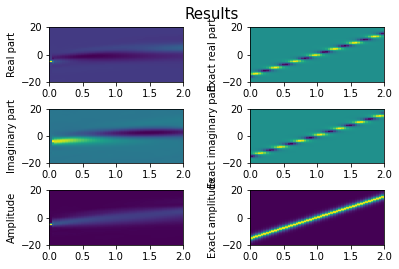

In [24]:
fig, ax = plt.subplots(3, 2)

plt.suptitle("Results", fontsize=15, x=0.5, y=0.95)

ax[0, 0].set_ylabel("Real part")
ax[0, 0].imshow(
    u.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)
ax[1, 0].set_ylabel("Imaginary part")
ax[1, 0].imshow(
    v.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)
ax[2, 0].set_ylabel("Amplitude")
ax[2, 0].imshow(
    q.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)

ax[0, 1].set_ylabel("Exact real part")
ax[0, 1].imshow(
    u_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)
ax[1, 1].set_ylabel("Exact imaginary part")
ax[1, 1].imshow(
    v_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)
ax[2, 1].set_ylabel("Exact amplitude")
ax[2, 1].imshow(
    q_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

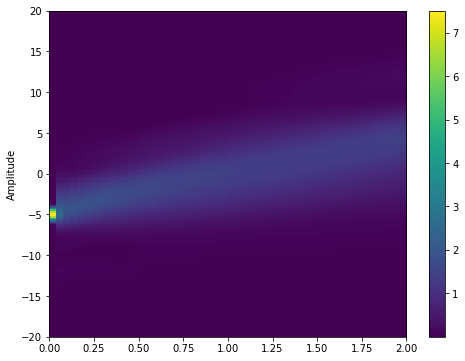

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.set_ylabel("Amplitude")

im = ax.imshow(
    q.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)

plt.colorbar(im, ax=ax)
plt.show()

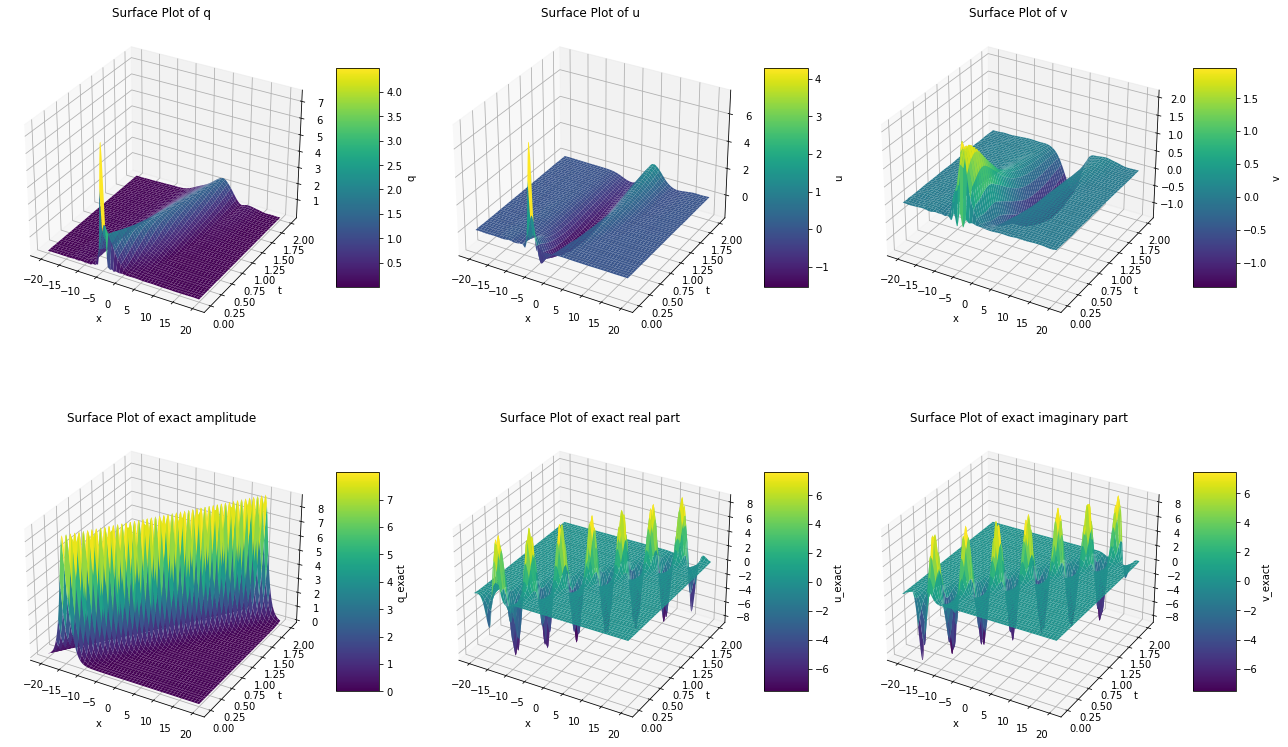

In [26]:
fig = plt.figure(figsize=(18, 12))

ax1 = fig.add_subplot(231, projection='3d')
surf1 = ax1.plot_surface(X, T, q, cmap='viridis', edgecolor='none')
cbar1 = fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
cbar1.set_label('q')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_title('Surface Plot of q')

ax2 = fig.add_subplot(232, projection='3d')
surf2 = ax2.plot_surface(X, T, u, cmap='viridis', edgecolor='none')
cbar2 = fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
cbar2.set_label('u')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_title('Surface Plot of u')

ax3 = fig.add_subplot(233, projection='3d')
surf3 = ax3.plot_surface(X, T, v, cmap='viridis', edgecolor='none')
cbar3 = fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)
cbar3.set_label('v')
ax3.set_xlabel('x')
ax3.set_ylabel('t')
ax3.set_title('Surface Plot of v')

ax4 = fig.add_subplot(234, projection='3d')
surf4 = ax4.plot_surface(X, T, q_exact(X, T), cmap='viridis', edgecolor='none')
cbar4 = fig.colorbar(surf4, ax=ax4, shrink=0.5, aspect=5)
cbar4.set_label('q_exact')
ax4.set_xlabel('x')
ax4.set_ylabel('t')
ax4.set_title('Surface Plot of exact amplitude')

ax5 = fig.add_subplot(235, projection='3d')
surf5 = ax5.plot_surface(X, T, u_exact(X, T), cmap='viridis', edgecolor='none')
cbar5 = fig.colorbar(surf5, ax=ax5, shrink=0.5, aspect=5)
cbar5.set_label('u_exact')
ax5.set_xlabel('x')
ax5.set_ylabel('t')
ax5.set_title('Surface Plot of exact real part')

ax6 = fig.add_subplot(236, projection='3d')
surf6 = ax6.plot_surface(X, T, v_exact(X, T), cmap='viridis', edgecolor='none')
cbar6 = fig.colorbar(surf6, ax=ax6, shrink=0.5, aspect=5)
cbar6.set_label('v_exact')
ax6.set_xlabel('x')
ax6.set_ylabel('t')
ax6.set_title('Surface Plot of exact imaginary part')

plt.tight_layout()
plt.show()

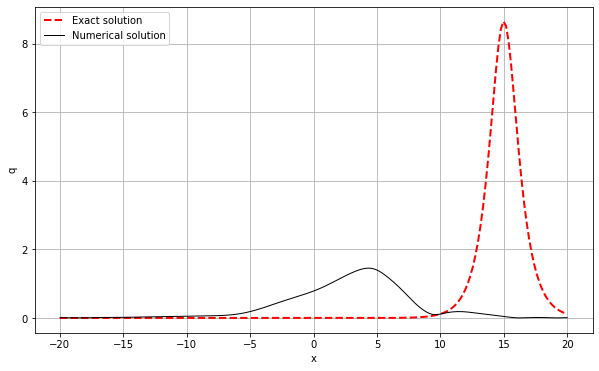

In [27]:
q_exact_values = q_exact(x, t_upper)

plt.figure(figsize=(10, 6))
plt.plot(x, q_exact_values, 'r--', label='Exact solution', linewidth=2)
plt.plot(x, q[-1, :], 'k-', label='Numerical solution', linewidth=1)
plt.xlabel('x')
plt.ylabel('q')
plt.legend()
plt.grid()
plt.show()